## 范数和权重衰减

在训练参数化机器学习模型时，权重衰减（decay weight）是最广泛应用的正则化技术之一，它通常也被称为$L_2$正则化。这项技术通过函数与零的距离来衡量函数的复杂度，
因为在所有函数$f$中，函数$f = 0$（所有输入都得到值$0$）
在某种意义上是最简单的。

一种简单的方法是通过线性函数
$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$
中的权重向量的某个范数来度量其复杂性，
例如$\| \mathbf{w} \|^2$。
要保证权重向量比较小，
最常用方法是将其范数作为惩罚项加到最小化损失的问题中。
将原来的训练目标最小化训练标签上的预测损失，
调整为最小化预测损失和惩罚项之和。

损失由下式给出：

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

$\mathbf{x}^{(i)}$是样本$i$的特征，
$y^{(i)}$是样本$i$的标签，
$(\mathbf{w}, b)$是权重和偏置参数。

为了惩罚权重向量的大小，
必须以某种方式在损失函数中添加$\| \mathbf{w} \|^2$，
我们通过*正则化常数*$\lambda$来描述这种权衡，
这是一个非负超参数，我们使用验证数据拟合：

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2,$$

对于$\lambda = 0$，我们恢复了原来的损失函数。
对于$\lambda > 0$，我们限制$\| \mathbf{w} \|$的大小。
这里我们仍然除以$2$：当我们取一个二次函数的导数时，
$2$和$1/2$会抵消。

通过平方$L_2$范数，我们去掉平方根，留下权重向量每个分量的平方和。
这使得惩罚的导数很容易计算：导数的和等于和的导数。

$L_2$正则化回归的小批量随机梯度下降更新如下式：

$$
\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}
$$

我们根据估计值与观测值之间的差异来更新$\mathbf{w}$。
然而，我们同时也在试图将$\mathbf{w}$的大小缩小到零。
这就是为什么这种方法有时被称为*权重衰减*。
我们仅考虑惩罚项，优化算法在训练的每一步*衰减*权重。
与特征选择相比，权重衰减为我们提供了一种连续的机制来调整函数的复杂度。
较小的$\lambda$值对应较少约束的$\mathbf{w}$，
而较大的$\lambda$值对$\mathbf{w}$的约束更大。

是否对相应的偏置$b^2$进行惩罚在不同的实践中会有所不同，
在神经网络的不同层中也会有所不同。
通常，网络输出层的偏置项不会被正则化。

## 利用高维线性回归实现权重衰减

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

首先生成数据，生成公式如下：

**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**

选择标签是关于输入的线性函数。
标签同时被均值为0，标准差为0.01高斯噪声破坏。
为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，
并使用一个只包含20个样本的小训练集。

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 初始化模型参数

定义一个函数来随机初始化模型参数



In [3]:
def init_params():
    w = torch.normal(0, 1, size = (num_inputs, 1), requires_grad = True)
    b = torch.zeros(1, requires_grad = True)
    return [w, b]

### 定义$L_2$范数惩罚

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### 定义训练代码实现

下面的代码将模型拟合训练数据集，并在测试数据集上进行评估。

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### 忽略正则化直接训练

用lamdb=0禁用权重衰减后运行代码。此时训练误差有所减少，但测试误差没有减少，这意味着出现了严重的过拟合。

w的L2范数是： 14.971677780151367


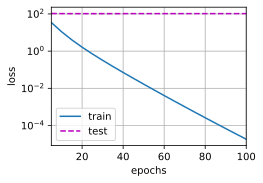

In [6]:
train(lambd = 0)

### 使用权重衰减

使用权重衰减来运行代码。此时训练误差增大，但测试误差减小。这正是我们期望从正则化中得到的效果。

w的L2范数是： 0.34405317902565


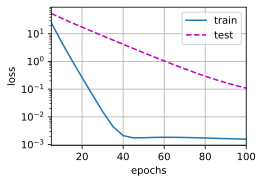

In [7]:
train(lambd = 3)

## 权重衰减的简洁实现

在实例化优化器时直接通过weight_decay指定weight decay超参数。默认情况下，PyTorch同时衰减权重和便宜。这里只为权重设置了weight_decay，所以偏置参数$b$不会衰减。

In [8]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.416662216186523


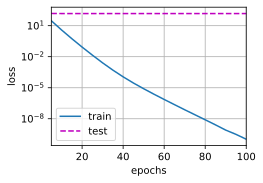

In [9]:
train_concise(0)

w的L2范数： 0.39273694157600403


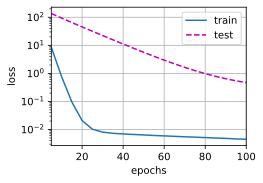

In [10]:
train_concise(3)